In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
import time

In [2]:
from pylab import *
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

## Get the Illustris data

In [3]:
tng_data = []
tng_labels = []

for i in np.random.choice(1000,1000, replace=False):
    pk = np.loadtxt('/Users/anamaria/Desktop/Full_Hydro/IllustrisTNG/%d/Pk_m_z=5.00.txt'%i)
    mask = pk[:,0] <=30.0
    pk_new = pk[mask]
    cosmo_params = np.loadtxt('/Users/anamaria/Desktop/Full_Hydro/hydro_DL/IllustrisTNG/latin_hypercube_params.txt')[i]
    tng_data.append(pk_new)
    tng_labels.append(cosmo_params[0:2])

In [4]:
len(tng_data)

1000

In [5]:
len(tng_labels)

1000

In [6]:
tng_sims= np.array(tng_data).reshape(len(tng_data),-1)
tng_params = np.array(tng_labels)

In [10]:
tng_sims.shape

(1000, 236)

## Get the SIMBA data


In [7]:
simba_data = []
simba_labels = []

for i in np.random.choice(1000,1000, replace=False):
    pk = np.loadtxt('/Users/anamaria/Desktop/Full_Hydro/SIMBA/%d/Pk_m_z=5.00.txt'%i)
    mask = pk[:,0] <=30.0
    pk_new = pk[mask]
    cosmo_params = np.loadtxt('/Users/anamaria/Desktop/Full_Hydro/hydro_DL/SIMBA/latin_hypercube_params.txt')[i]
    simba_data.append(pk_new)
    simba_labels.append(cosmo_params[0:2])

In [8]:
simba_sims= np.array(simba_data).reshape(len(simba_data),-1)
simba_params = np.array(simba_labels)

In [9]:
simba_sims.shape

(1000, 236)

# Train the model on SIMBA

In [11]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5,max_depth=4, n_jobs= 5)

In [12]:

start= time.time()

model.fit(simba_sims, simba_params)

print('Time (s):', "{:.4f}".format((time.time()-start)))

Time (s): 0.9842


## Test the model on Illustris TNG

In [13]:
ypred=model.predict(tng_sims)

<Figure size 432x288 with 0 Axes>

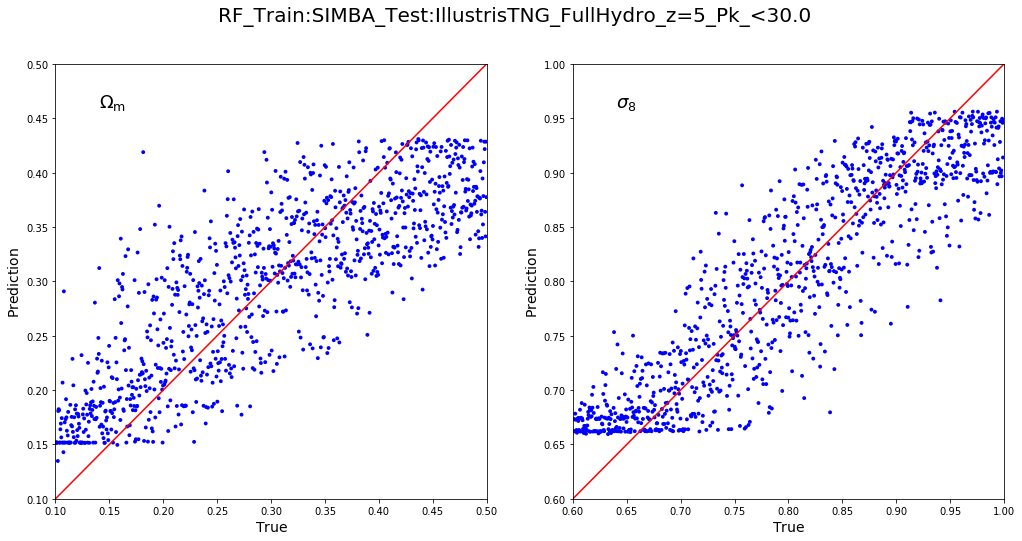

In [14]:
fig = figure()
fig = figure(figsize=(17,8))     #give dimensions to the figure

#gs =  gridspec.GridSpec(2,3height_ratios=[1,1,1],width_ratios[1,1])
gs =  gridspec.GridSpec(1,2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
#ax3 = plt.subplot(gs[2])
#ax4 = plt.subplot(gs[3])
#ax5 = plt.subplot(gs[4])
#ax6 = plt.subplot(gs[5])

x_min, x_max = 0.1, 0.5
y_min, y_max = 0.1, 0.5

#param_min = [0.1, 0.03, 0.5, 0.8, 0.6]
#param_max = [0.5, 0.07, 0.9, 1.2, 1.0]

param_min = [0.1, 0.6]
param_max = [0.5, 1.0]

#label = [r"$\Omega_{\rm m}$", r"$\Omega_{\rm b}$", r"$h$",
         #r"$n_{\rm s}$", r"$\sigma_8$"]

label = [r"$\Omega_{\rm m}$", r"$\sigma_8$"]

x_dumb = np.linspace(-15,15,100) #larger values for when outliers are included in plot


for i,ax in enumerate([ax1,ax2]):

    ax.set_xlim([param_min[i],param_max[i]])
    ax.set_ylim([param_min[i],param_max[i]])
    #ax.set_xlim([np.min(true_values[:,i]), np.max(true_values[:,i])]) #for plotting the ouliers
    #ax.set_ylim([1.05*np.min(pred_values[:,i]), 1.05*np.max(pred_values[:,i])]) #for plotting the outliers


    ax.set_xlabel(r'${\rm True}$',fontsize=14)
    ax.set_ylabel(r'${\rm Prediction}$',fontsize=14)

    p1=ax.scatter(tng_params[:,i], ypred[:,i],c='b',edgecolor='none',s=15,marker='o', )
    ax.plot(x_dumb, x_dumb, linestyle='-', c='r')
    
    posx = param_min[i] + 0.1*(param_max[i] - param_min[i])
    posy = param_min[i] + 0.9*(param_max[i] - param_min[i])
    ax.text(posx, posy, label[i], size=18)
    
    #ax.legend(loc='lower right')



suptitle('RF_Train:SIMBA_Test:IllustrisTNG_FullHydro_z=5_Pk_<30.0', fontsize=20)  #for title with several panels

savefig('RF_SIMBA_Illustris_mix_Pk_<30_11_18.pdf', bbox_inches='tight')

## Obtain RMSE Scores

In [15]:
def obtain_cosmo_params_rmse(test_data, prediction_data, title):
    scores={}
    #maxmin={}
    om_score =np.sqrt(metrics.mean_squared_error(test_data[:,0],prediction_data[:,0]))
    s8_score =np.sqrt(metrics.mean_squared_error(test_data[:,1],prediction_data[:,1]))
    scores.update([('omega m rmse', om_score)])
    scores.update([('sigma 8 rmse', s8_score)])
    np.save(title, scores)
    
    #maxmin.update([(('omega m min', np.min(prediction_data[:,0])), ('omega m max', np.max(prediction_data[:,0])))])
    #maxmin.update([(('sigma 8 min', np.min(prediction_data[:,1])), ('sigma 8 max', np.max(prediction_data[:,1])))])
    
    return scores, #maxmin

In [16]:
obtain_cosmo_params_rmse(tng_params, ypred, 'RF_SIMBA_Illustris_Full_Pk_30_11_17')

({'omega m rmse': 0.06605580934827274, 'sigma 8 rmse': 0.049238571729876106},)